<a href="https://colab.research.google.com/github/ItamarBerger/TabularDS-part1/blob/main/TDS_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1061]:
!git clone https://github.com/ItamarBerger/TabularDS-part1

fatal: destination path 'TabularDS-part1' already exists and is not an empty directory.


## Load part-1 baseline model

In [1062]:
# Import necessary libraries
import pandas as pd
import numpy as np
import joblib

# Load the saved model
model = joblib.load('/content/TabularDS-part1/models/part1_model.pkl')

# Load the same dataset to ensure consistency
dtf = pd.read_csv('/content/TabularDS-part1/data/avocado.csv')


In [1063]:
dtf_base = dtf.copy()
dtf_base.columns = dtf_base.columns.str.replace(' ', '')
dtf_base['Date'] = pd.to_datetime(dtf_base['Date'])

dtf_base['type'] = dtf_base['type'].map({'organic': 1, 'conventional': 0})
le = LabelEncoder()

# Apply label encoding to the 'region' column
dtf_base['region'] = le.fit_transform(dtf_base['region'])

dtf_base.drop('Date', axis=1, inplace=True)

dtf_train, dtf_test = train_test_split(dtf_base,
                      test_size=0.25)
X_train = dtf_train.drop('AveragePrice',axis=1)
X_test = dtf_test.drop('AveragePrice',axis=1)


y_train = dtf_train['AveragePrice']
y_test = dtf_test['AveragePrice']

model = xgb.XGBRegressor()
prediction = model.fit(X_train,y_train).predict(X_test)

# Error anaylasis and work plan
## intro:
As we recall, our baseline from part-1 already had pretty solid performance (r2 , MSE, residuals, and propotional residuals).
Our goal in this notebook is to present creative approches for improving the baseline model

## Error Analysis Conclusions
1. We observed a sub-optimal RMSE score (around 0.11) in the baseline model.
2. Specifically noticed a model's tendency to underestimate
3. No difference in Avocado type in model's prediction error
4. High importance for the Date feature, which we didn't take into account last part. in this part we'll adress this issue.
5. Many features had skewed distribution or outliers on part-1

## Work-plan
0. Identify weaknesses in the initial model (some of them are listed here below)
1. Feature engeeniring
   - tramnsorming the **Date feature** into something more meaningful to help the model learn the relation we saw on part-1 between the date and the average avocado price

   - Adding **hidden feature** to complete totalVolume as sum of 3 different avocado volumes by sizes and a hidden amount of avocados not from those 3 categories.
2. Handling **outliers** more affectively than in part-1
3. Handling ** skewed features** using IQR

# Basic pre-processing and cleaning

In [1064]:
dtf = dtf.dropna()
#dtf.drop('Unnamed: 0', axis=1)
print(dtf.isnull().sum())
dtf.describe()

Unnamed: 0      0
Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64


,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
count,18249.000000,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000
mean,24.232232,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,2016.147899
std,15.481045,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.939938
min,0.000000,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000
25%,10.000000,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,2015.000000
50%,24.000000,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,2016.000000
75%,38.000000,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,2017.000000
max,52.000000,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,2018.000000


## Handle categorical columns

In [1065]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
dtf['type'] = dtf['type'].astype('category')
le = LabelEncoder()

# Apply label encoding to the 'region' column
dtf['region'] = dtf['region'].astype('category')

## Let's transform the Date feature into its core logical components (year, month, week)

In [1066]:
dtf.columns = dtf.columns.str.replace(' ', '')
dtf['Date'] = pd.to_datetime(dtf['Date'])
dtf['month'] = dtf['Date'].dt.month
dtf['year'] = dtf['Date'].dt.year
dtf['week'] = dtf['Date'].dt.isocalendar().week

dtf = dtf.drop('Date', axis=1)

dtf.head()

,Unnamed:0,AveragePrice,TotalVolume,4046,4225,4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,year,region,month,week
0,0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany,12,52
1,1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany,12,51
2,2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany,12,50
3,3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany,12,49
4,4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany,11,48


## Handle data skewness
- As we see below, the features plotted above are all:
  1. significantly right-skewed (high skew value).
  2. have heavy tail (high kurt value)


 Let's  try and fix it!

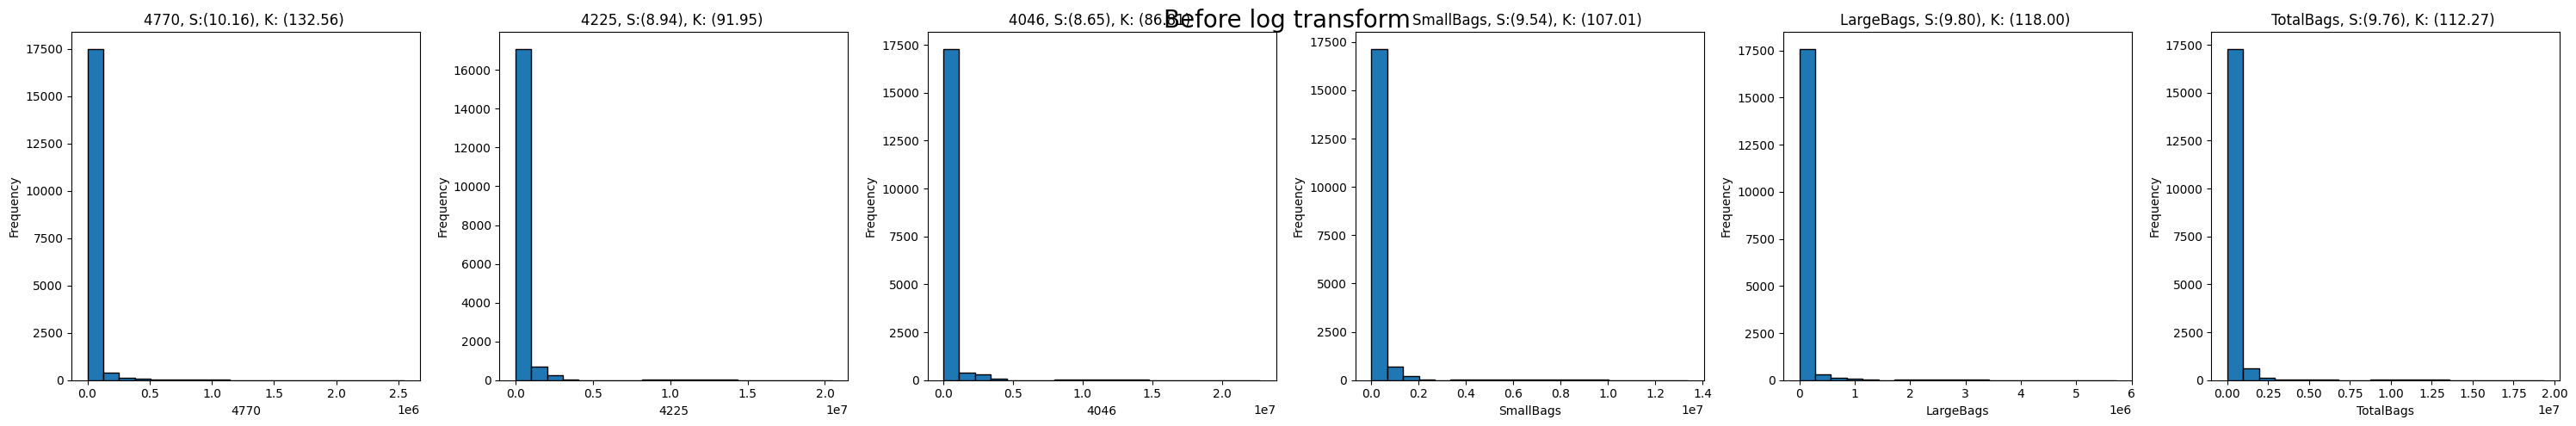

In [1067]:
import matplotlib.pyplot as plt
hardcoded_columns = ['4770', '4225', '4046', 'SmallBags', 'LargeBags', 'TotalBags']

def plot_columns_hists(dtf, title):
    # Determine the number of subplots needed (one for each column)
    num_columns = len(hardcoded_columns)

    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=num_columns, figsize=(5 * num_columns, 5))

    # Ensure axes is iterable (in case there's only one column)
    if num_columns == 1:
        axes = [axes]

    # Loop through the columns and plot each histogram
    for i, column in enumerate(hardcoded_columns):
        axes[i].hist(dtf[column], bins=20, edgecolor='black')
        axes[i].set_title(f"{column}, S:({dtf[column].skew():.2f}), K: ({dtf[column].kurt():.2f}) ")
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.suptitle(title, fontsize=20)
    plt.show()
import numpy as np
import pandas as pd
from scipy.stats import skew



plot_columns_hists(dtf, "Before log transform")


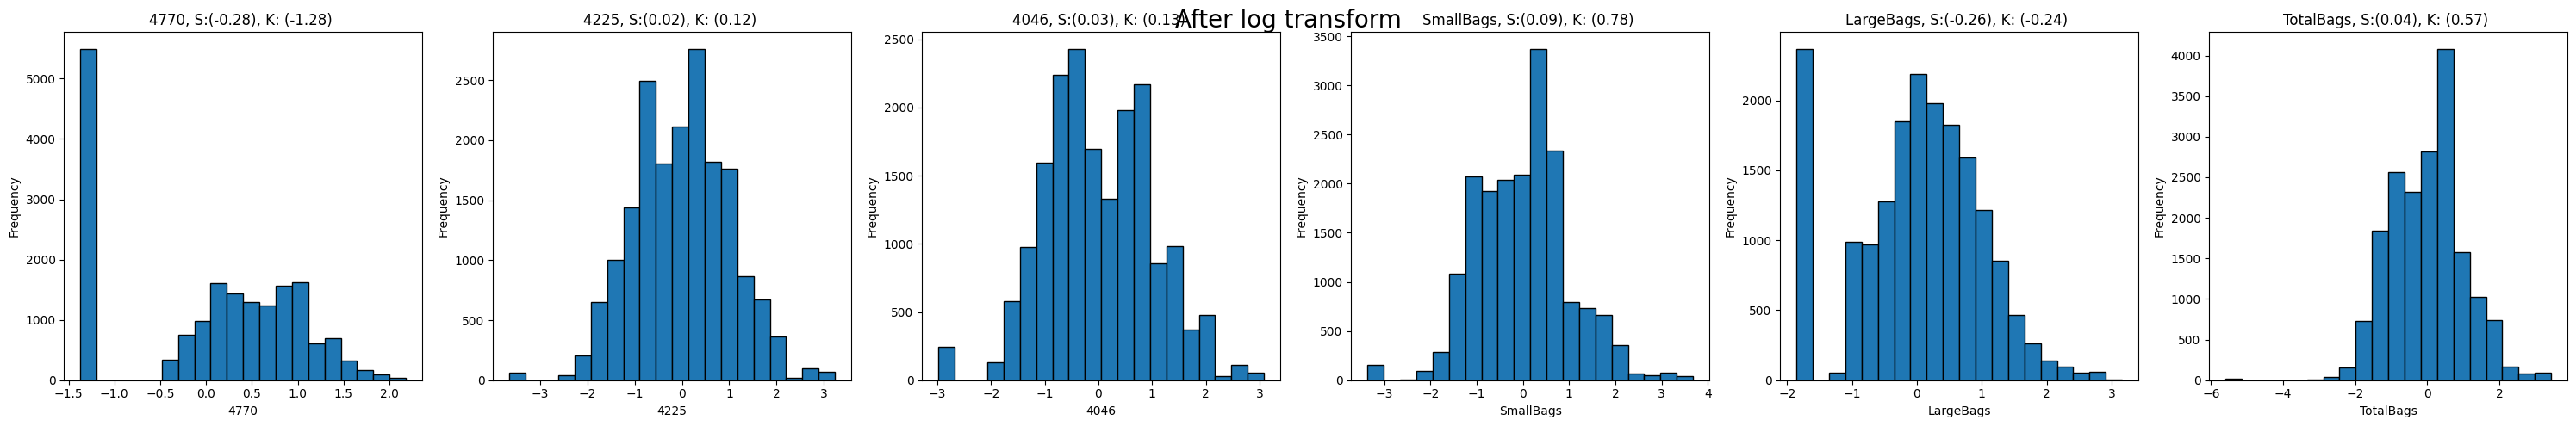

In [1068]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_boxplots(df):
    """
    This function creates a boxplot for each column in the DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    """
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 8))

    # Loop through each column in the DataFrame
    for i, column in enumerate(df.columns):
        plt.subplot(1, len(df.columns), i + 1)  # Create a subplot for each column
        sns.boxplot(data=df[column])  # Create boxplot for the column
        plt.title(f'Boxplot of {column}')
        plt.xticks([0], [column])  # Add label for the x-axis

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()




from sklearn.preprocessing import PowerTransformer
import pandas as pd

def box_cox_transform(dtf, column):
    # Initialize the PowerTransformer with method='box-cox'
    dtf[column] = dtf[column].clip(lower=1e-5)

    pt = PowerTransformer(method='box-cox')

    # Apply the Box-Cox transformation (requires data in 2D)
    transformed = pt.fit_transform(dtf[[column]])

    # The result is a 2D array, so return it as a pandas Series for easier handling
    return pd.Series(transformed.flatten(), index=dtf.index, name=column)

hardcoded_columns = ['4770', '4225', '4046', 'SmallBags', 'LargeBags', 'TotalBags']
for col in hardcoded_columns:
  dtf[col] = box_cox_transform(dtf, col)

plot_columns_hists(dtf, "After log transform")

## Results:
we can see now that all of the above feauters column, now have lower S and K values.  Overall most of them are now with S and K values close to 0 which is a great indication for data skewness.

## Moving On - Handling outliers affectively using IQR

In [1069]:
#data processing
import pandas as pd
import numpy as np
import scipy as sp

#statistics
from scipy import stats
import statsmodels.api as sm


#data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Machine learning library
import sklearn

import warnings
warnings.filterwarnings("ignore")

Number of samples in dataset before IQR: 18249


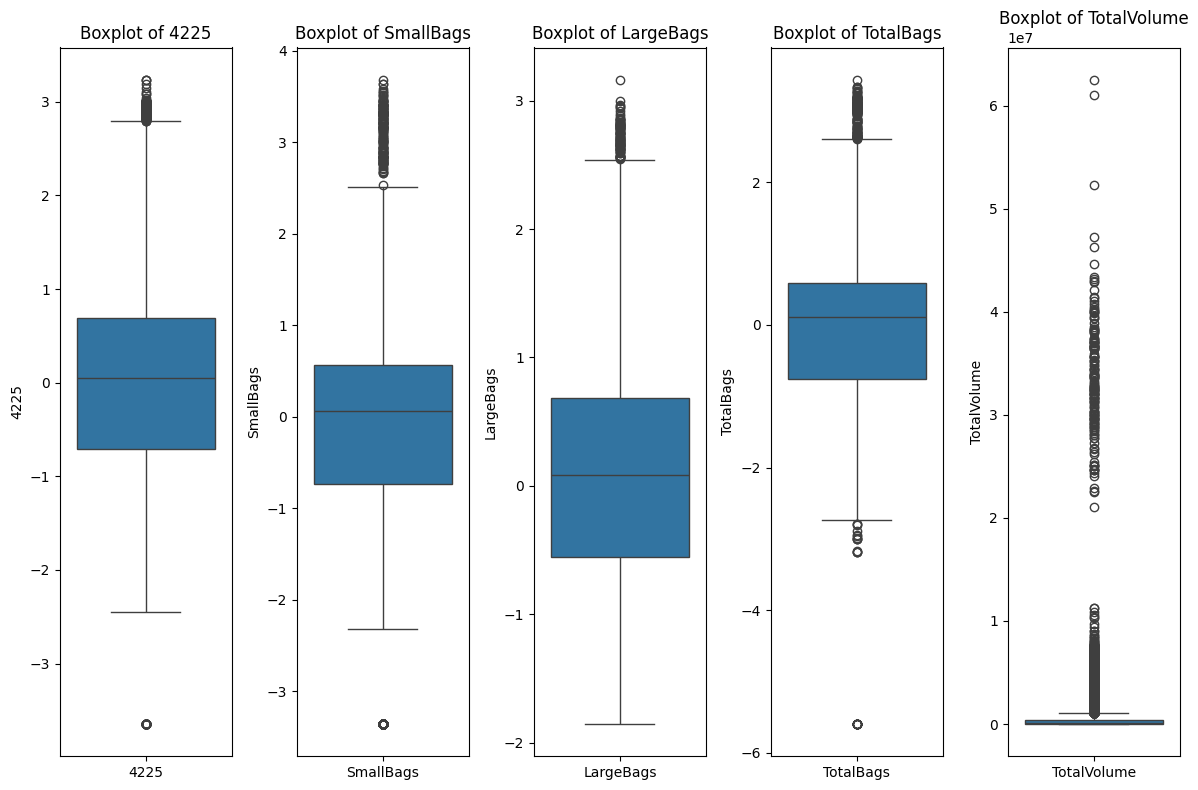

In [1070]:
import matplotlib.pyplot as plt
import seaborn as sns


# Call the function with your DataFrame
print('Number of samples in dataset before IQR: {}'.format(len(dtf)))
plot_boxplots(dtf[['4225', 'SmallBags', 'LargeBags', 'TotalBags', 'TotalVolume']])



### As the visualization above well demonstrate, There seem to be many outliers in the selected features. Let's adreess this using IQR method for outliers removal

Number of samples in dataset after IQR: 15667


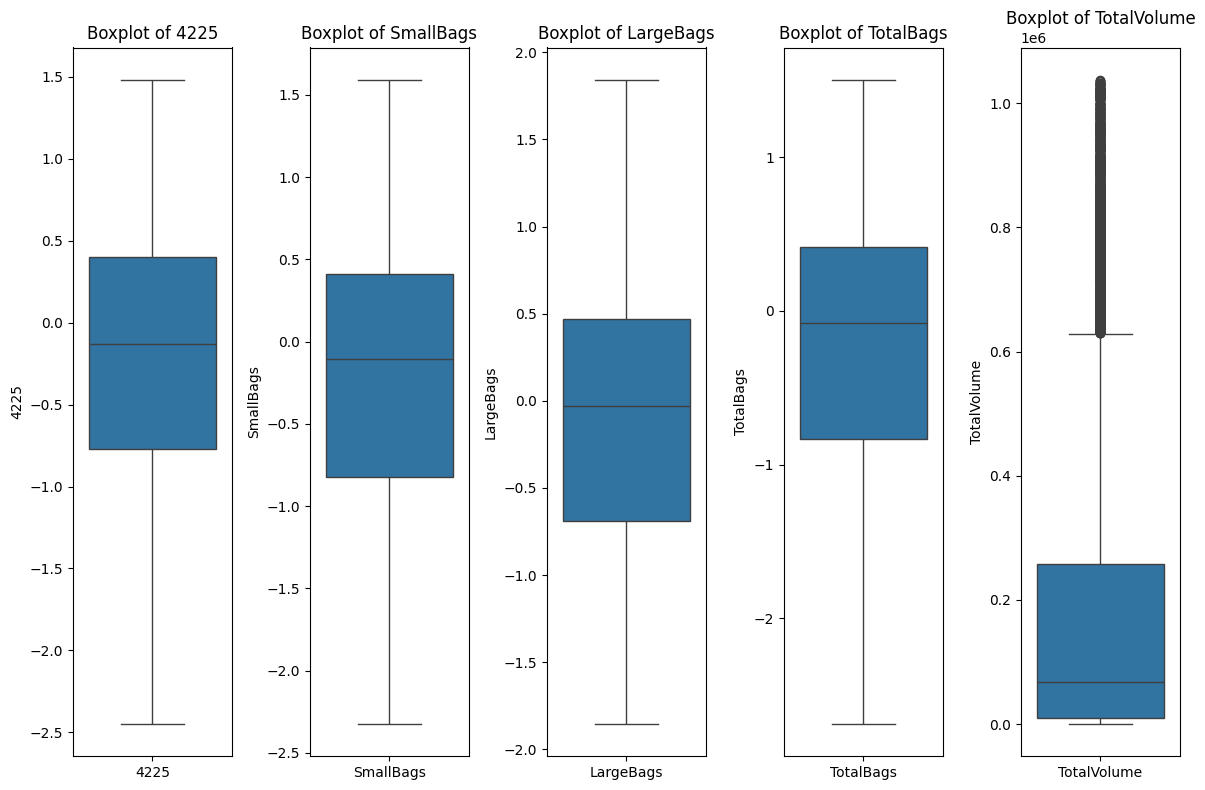

In [1071]:
hardcoded_columns = [ '4225', 'SmallBags', 'LargeBags', 'TotalBags', 'TotalVolume']



for nc in hardcoded_columns:

    iqr = dtf[nc].quantile(0.75) - dtf[nc].quantile(0.25)
    lo_bound = dtf[nc].quantile(0.25) - 1.5*iqr
    hi_bound = dtf[nc].quantile(0.75) + 1.5*iqr

    dtf = dtf[(dtf[nc] >= lo_bound) & (dtf[nc] <= hi_bound)]


print('Number of samples in dataset after IQR: {}'.format(len(dtf)))
plot_boxplots(dtf[hardcoded_columns])


### Notice that we were able to detect and remove ~700 (!) outliers.
Our data had some features with extreme values, and thus required special handling, which was absent on part-1)

## Summmary of feature engineering:
### so far we:

1) Used Box-Cox transformation to intelligently log-transform our left-skewed features.

2) Utilized IQR method for detection and removal of outliers (found ~700 outliers)

# Create & Train the new model

In [1072]:


dtf_train, dtf_test = train_test_split(dtf,
                      test_size=0.25)
dtf.head()

,Unnamed:0,AveragePrice,TotalVolume,4046,4225,4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,year,region,month,week
0,0,1.33,64236.62,-0.655138,0.283014,0.026740,-0.536364,-0.363840,-0.610645,0.0,conventional,2015,Albany,12,52
1,1,1.35,54876.98,-0.757803,0.207006,0.053692,-0.499557,-0.331371,-0.603067,0.0,conventional,2015,Albany,12,51
2,2,0.93,118220.22,-0.719010,0.558977,0.170468,-0.563369,-0.388146,-0.593410,0.0,conventional,2015,Albany,12,50
3,3,1.08,78992.15,-0.633715,0.391823,0.084826,-0.701000,-0.510809,-0.548029,0.0,conventional,2015,Albany,12,49
4,4,1.28,51039.60,-0.678452,0.200149,0.091021,-0.675851,-0.492443,-0.477231,0.0,conventional,2015,Albany,11,48


In [1073]:
#separate X from y
X_train = dtf_train.drop('AveragePrice',axis=1)
X_test = dtf_test.drop('AveragePrice',axis=1)


y_train = dtf_train['AveragePrice']
new_y_test = dtf_test['AveragePrice']

In [1074]:
import xgboost as xgb
new_model = xgb.XGBRegressor(enable_categorical=True)

In [1075]:
new_X_Train = X_train.copy()
new_X_Train.drop('XLargeBags', axis=1, inplace = True)
new_X_Train.reset_index(inplace=True)

new_X_Train.drop('Unnamed:0', axis=1, inplace=True)
new_X_Train.drop('index', axis=1, inplace=True)
new_X_Train.reset_index(drop=True, inplace=True)


new_X_test = X_test.copy()
new_X_test.drop('XLargeBags', axis=1, inplace = True)
new_X_test.reset_index(inplace=True)

new_X_test.drop('Unnamed:0', axis=1, inplace=True)
new_X_test.drop('index', axis=1, inplace=True)
new_X_test.reset_index(drop=True, inplace=True)

new_prediction = new_model.fit(new_X_Train,y_train).predict(new_X_test)
import joblib
#joblib.dump(model, '/TabularDS-part1/models/part1_model.pkl')

In [1076]:
from sklearn.metrics import r2_score,mean_squared_error ,mean_absolute_error
def evaluate_model(y_true, predictions):
    max_abs_error = np.max(np.abs(y_true - predictions))
    mae = mean_absolute_error(y_true, predictions)
    rmse = np.sqrt(mean_squared_error(y_true, predictions))
    r2 = r2_score(y_true, predictions)
    corr_coefficient, _ = pearsonr(y_true, predictions)
    return max_abs_error, mae, rmse, r2, corr_coefficient

# Evaluate both models
baseline_metrics = evaluate_model(y_test, prediction)
new_model_metrics = evaluate_model(new_y_test, new_prediction)

# Print out the results for comparison
print("Baseline Model Metrics:")
print(f"Max_Abs_Error: {baseline_metrics[0]:.3f}, Mean_Abs_Error: {baseline_metrics[1]:.3f}, RMSE: {baseline_metrics[2]:.2f}, R^2: {baseline_metrics[3]:.3f}, Pearson: {baseline_metrics[4]:.3f}")
print("\nNew Model Metrics:")
print(f"Max_Abs_Error: {new_model_metrics[0]:.3f}, Mean_Abs_Error: {new_model_metrics[1]:.3f}, RMSE: {new_model_metrics[2]:.2f}, R^2: {new_model_metrics[3]:.3f}, Pearson: {new_model_metrics[4]:.3f}")


Baseline Model Metrics:
MAX_ABS_ERR: 0.752, MAE: 0.089, RMSE: 0.12, R^2: 0.906, Pearson: 0.952

New Model Metrics:
MAX_ABS_ERR: 0.759, MAE: 0.076, RMSE: 0.11, R^2: 0.927, Pearson: 0.963


## As we can see, we did mange to achieve some improvements!:
1) out greatest improvement is in R square (**0.9 -> 0.92**)

2) pearson correlation also improved, suggestin there's now stronger corrlation between actual prices and out model's predictions

3) Some more settle improvements in: RMSE and MAE (Mean Absolute Error)

### also a slight regression in MAX_ABS_ERR.
(It's important to recall that this is a metric which represents a single prediction, not all of them, as oppose to the rest of the metrics)

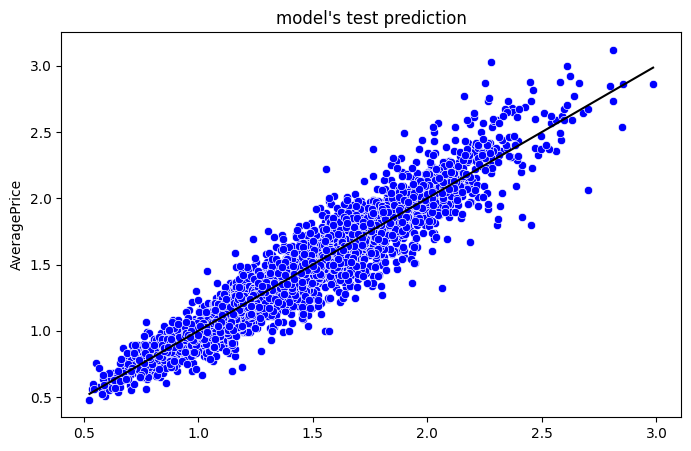

In [1077]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x = prediction,y = y_test,ax=ax,color='blue')
sns.lineplot(x = prediction,y = prediction,ax=ax,color='black')
plt.title("model's test prediction")
plt.show()

ValueError: array length 4563 does not match index length 7994

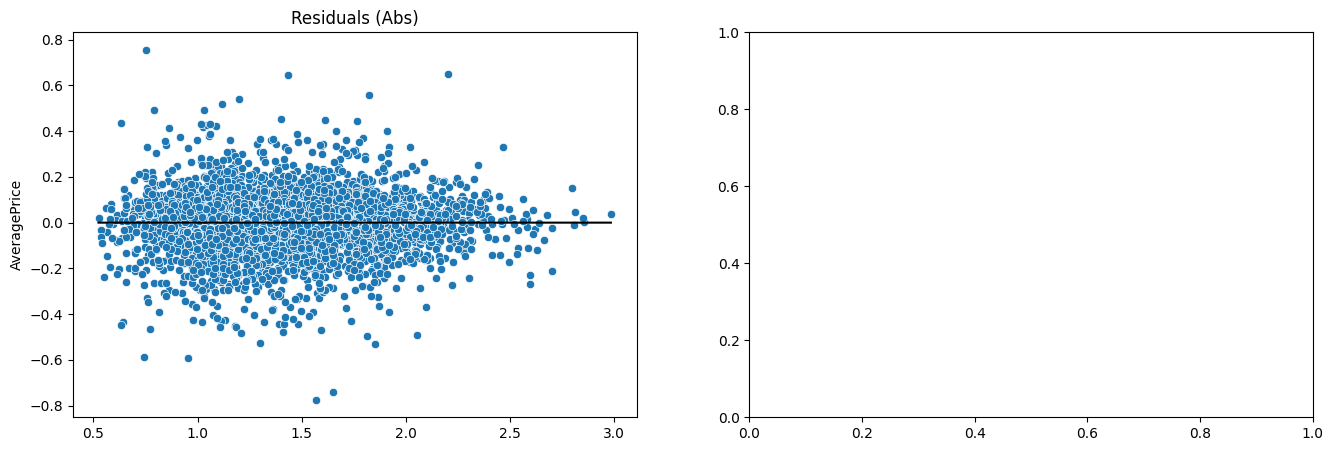

In [1078]:
fig, ax = plt.subplots(1,2,figsize=(16,5))
sns.scatterplot(x=prediction,y=residuals,ax=ax[0])
sns.lineplot(x=prediction,y=0,ax=ax[0],color='black')
ax[0].set_title("Residuals (Abs)")
sns.scatterplot(x=prediction,y=residuals/y_test,ax=ax[1])
sns.lineplot(x=prediction,y=0,ax=ax[1],color='black')
ax[1].set_title("Residuals (%)")
plt.show()

In [ ]:
# Plotting feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(new_model, importance_type='weight', max_num_features=10, height=0.8)
plt.title('Feature Importance')
plt.show()